In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

C:\Users\zm_if\AppData\Local\Temp\ipykernel_10148\3932296997.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [14]:
data = pd.read_csv("data/ridership_data.csv", parse_dates=["service_date"])

In [16]:
data.columns = ["date", "day_type", "bus", "rail", "total"]
data = data.sort_values("date").set_index("date")
data = data.drop(columns="total")
data = data.drop_duplicates()

In [17]:
data.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


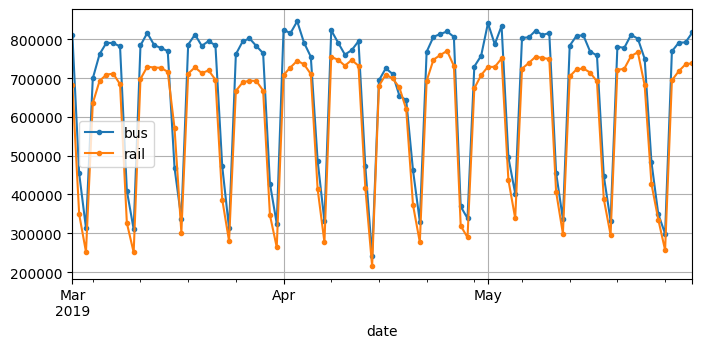

In [24]:
data.loc["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

In [25]:
custom_df = data.loc["2019-03": "2019-05"]

In [30]:
# diff 7 --> value at time t minus value at time t-7
diff_7 = custom_df[["bus","rail"]].diff(7)

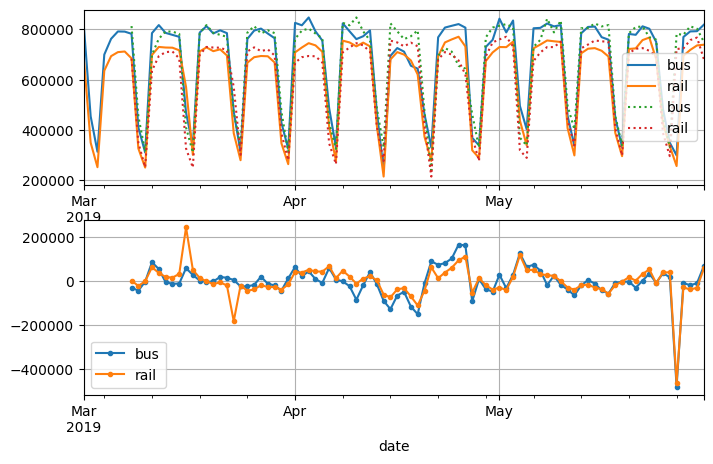

In [44]:
fig, axs = plt.subplots(2,1, figsize=(8,5))
custom_df.plot(ax=axs[0])
custom_df.shift(7).plot(ax=axs[0], linestyle=":", grid=True)
diff_7.plot(ax=axs[1], grid=True, marker=".")
plt.show()
